# repeated measures ANOVA for simulated data



Read in the data & import packages

In [ ]:
%%capture
!pip install pymc3
!pip install pingouin

In [ ]:
import arviz as az
import pingouin as pg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy.stats import norm
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.anova import AnovaRM
import random
import math as m
sns.set_context('talk')

In [ ]:
random.seed(42)

Import the simulated data set.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
simulated_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Statistical Consulting Project/simulated_data_fit.csv')

simulated_df = simulated_df.drop("Unnamed: 0", axis = 1)
simulated_df = simulated_df.dropna()
simulated_df

,subjectID,modality,dose,session,bias,precision
0,sub_0225,Intero,0,1,-12.525,9.532
1,sub_0225,Intero,5,2,-13.674,20.803
2,sub_0225,Intero,10,3,-8.570,18.582
3,sub_0225,Intero,15,4,-6.831,20.775
4,sub_0225,Extero,0,1,0.074,6.750
...,...,...,...,...,...,...
379,sub_0191,Intero,15,1,2.772,18.629
380,sub_0191,Extero,0,4,1.435,9.557
381,sub_0191,Extero,5,3,1.280,9.252
382,sub_0191,Extero,10,2,-0.564,10.501


# Assumptioms RM anova
If we want to use Repeated measurement ANOVA, we have to check several assumptions: 
1. The dependent variable is
measured at a continuous scale. 
2. The independent variable consists of at least two or more
groups that are related or have ”matched pairs”. This means that the participants are present
in both groups. 
3. In the related groups, no significant/spurious outliers should be present.
To test this assumption, visualize the data by making boxplots. 
4. The dependent variable
is (near-to) normally distributed for each group. Data can be approximately normal because
RM ANOVA is quite robust to violations of normality (the results will still be valid if the data
is slightly non-normal), however a solution for this is transformation. To test for normality,
different options are available such as the Shapiro-Wilk test. 
5. The variances of the differences between all combinations of related groups are the same (this is called spheriticty)

# Normality
Check if the dependent variable is (near to) normally disributed for each group.

The Shapiro-Wilk test:

In [ ]:
e = pg.normality(data=simulated_df, dv="precision", group = "modality")
f = pg.normality(data=simulated_df, dv="bias", group = "modality")
print(e,f)
e = pg.normality(data=simulated_df, dv="precision", group = "dose")
f = pg.normality(data=simulated_df, dv="bias", group = "dose")
print(e,f)

               W          pval  normal
Intero  0.836504  2.042335e-13   False
Extero  0.787134  1.941999e-15   False                W      pval  normal
Intero  0.978535  0.004787   False
Extero  0.956052  0.000011   False
           W          pval  normal
0   0.690237  6.249525e-13   False
5   0.797868  3.757135e-10   False
10  0.783970  1.468711e-10   False
15  0.821765  2.096749e-09   False            W      pval  normal
0   0.897799  0.000002   False
5   0.926047  0.000043   False
10  0.950286  0.001143   False
15  0.980238  0.156652    True


This indicates that the normality assumption is violated in most cases. We inspect the corresponding histograms:

(array([ 5.,  4.,  9., 11., 24., 25., 14.,  1.,  2.,  1.]),
 array([-17.512, -14.099, -10.686,  -7.273,  -3.86 ,  -0.447,   2.966,
          6.379,   9.792,  13.205,  16.618]),
 <a list of 10 Patch objects>)

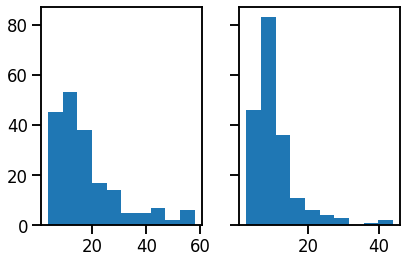

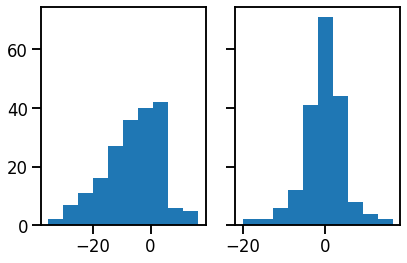

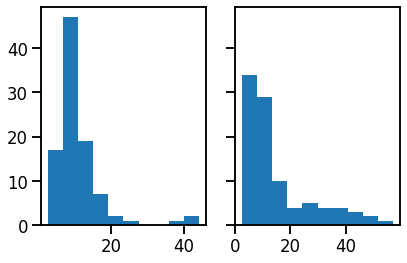

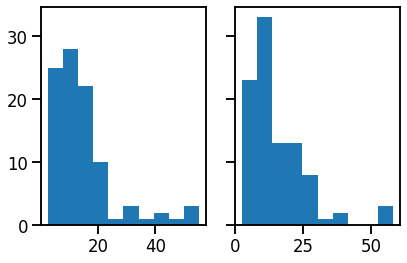

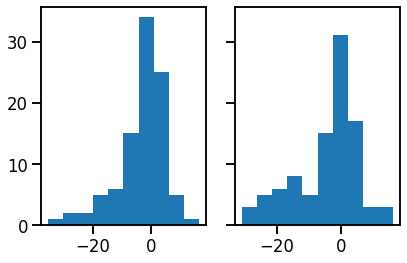

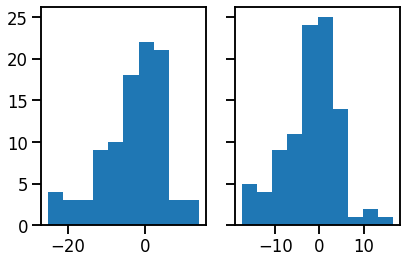

In [ ]:
# intero & extero for precision and bias
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(simulated_df[simulated_df.modality =="Intero"]["precision"])
axs[1].hist(simulated_df[simulated_df.modality =="Extero"]["precision"])

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(simulated_df[simulated_df.modality =="Intero"]["bias"])
axs[1].hist(simulated_df[simulated_df.modality =="Extero"]["bias"])

# all doses for precision
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(simulated_df[simulated_df.dose ==0]["precision"])
axs[1].hist(simulated_df[simulated_df.dose ==5]["precision"])

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(simulated_df[simulated_df.dose ==10]["precision"])
axs[1].hist(simulated_df[simulated_df.dose ==15]["precision"])
# all doses for bias
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(simulated_df[simulated_df.dose ==0]["bias"])
axs[1].hist(simulated_df[simulated_df.dose ==5]["bias"])

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(simulated_df[simulated_df.dose ==10]["bias"])
axs[1].hist(simulated_df[simulated_df.dose ==15]["bias"])

The histograms confirm that not all combinations are normally distributed. To solve this issue, we apply a cube root transformation to the bias and a log transofmration to the precision.

In [ ]:
new_dataframe_sdf = simulated_df.copy()
new_dataframe_sdf['precision'] = np.log(simulated_df["precision"])
new_dataframe_sdf['bias'] = simulated_df["bias"]**(1/3)

Using the transformed data, we again do the Saphiro-Wilk test.

In [ ]:
e = pg.normality(data=new_dataframe_sdf, dv="precision", group = "modality")
f = pg.normality(data=new_dataframe_sdf, dv="bias", group = "modality")
print(e,f)

e = pg.normality(data=new_dataframe_sdf, dv="precision", group = "dose")
f = pg.normality(data=new_dataframe_sdf, dv="bias", group = "dose")
print(e,f)

               W      pval  normal
Intero  0.985741  0.049303   False
Extero  0.979927  0.007408   False                W      pval  normal
Intero  0.971219  0.191147    True
Extero  0.985153  0.339466    True
           W      pval  normal
0   0.946589  0.000666   False
5   0.966877  0.015720   False
10  0.985004  0.345524    True
15  0.991191  0.782311    True            W      pval  normal
0   0.980717  0.769272    True
5   0.970142  0.333885    True
10  0.968287  0.380621    True
15  0.968579  0.309641    True


Display the histograms for those combinations for which the normality assumption is still violated:

(array([ 2.,  7., 13., 12., 26.,  8.,  9.,  7.,  7.,  5.]),
 array([0.9439059 , 1.25395193, 1.56399796, 1.87404399, 2.18409002,
        2.49413605, 2.80418208, 3.1142281 , 3.42427413, 3.73432016,
        4.04436619]),
 <a list of 10 Patch objects>)

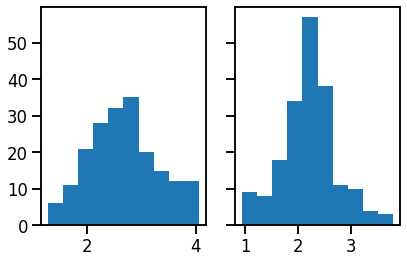

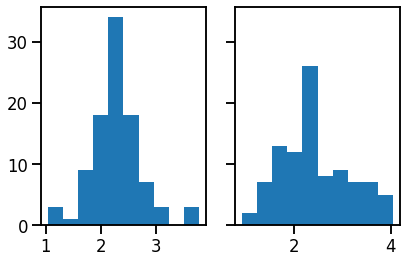

In [ ]:
# intero & extero for precision
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(new_dataframe_sdf[new_dataframe_sdf.modality =="Intero"]["precision"])
axs[1].hist(new_dataframe_sdf[new_dataframe_sdf.modality =="Extero"]["precision"])

# doses 0 and 5 for precision
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(new_dataframe_sdf[new_dataframe_sdf.dose ==0]["precision"])
axs[1].hist(new_dataframe_sdf[new_dataframe_sdf.dose ==5]["precision"])

We consider these histograms to be normal enough. Since the RM ANOVA is not overly sensitive to violations of the normality assumption, we continue with the transformed data as it is.

# Outliers

We check for outliers in the data using boxplots.

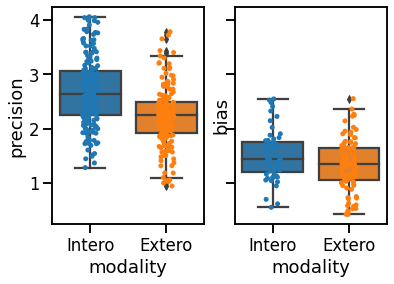

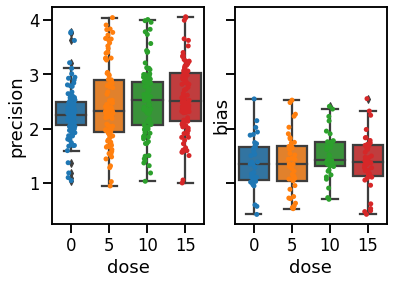

In [ ]:
fig, (ax1,ax2) =plt.subplots(ncols=2, sharey=True)
sns.boxplot(x="modality", y ="precision", data=new_dataframe_sdf , ax=ax1)
sns.stripplot(x="modality", y ="precision", data=new_dataframe_sdf, ax=ax1)
sns.boxplot(x="modality", y ="bias", data=new_dataframe_sdf,ax=ax2 )
sns.stripplot(x="modality", y ="bias", data=new_dataframe_sdf, ax=ax2)

fig, (ax1,ax2) =plt.subplots(ncols=2, sharey=True)
sns.boxplot(x="dose", y ="precision", data=new_dataframe_sdf , ax=ax1)
sns.stripplot(x="dose", y ="precision", data=new_dataframe_sdf, ax=ax1)
sns.boxplot(x="dose", y ="bias", data=new_dataframe_sdf,ax=ax2 )
sns.stripplot(x="dose", y ="bias", data=new_dataframe_sdf, ax=ax2)

There are no extreme outliers and we consider this assumption met.

# Sphericity

We check the sphericity assumption using Mauchly's test.

In [ ]:
a = pg.sphericity(data=new_dataframe_sdf, dv="precision", subject = "subjectID" ,within = "modality")[-1]
b =pg.sphericity(data=new_dataframe_sdf, dv="bias", subject = "subjectID" ,within = "modality")[-1]
c = pg.sphericity(data=simulated_df, dv="precision", subject = "subjectID" ,within = "dose")[-1]
d =pg.sphericity(data=new_dataframe_sdf, dv="bias", subject = "subjectID" ,within = "dose")[-1]
print(a,b,c,d)

1.0 1.0 2.711273876324755e-05 0.5065663528649584


The assumption is violated for the dose effect on the precision. This means the p-value for this effect needs to be corrected (see below).

# 2-way repeated measures ANOVA 
The 2-way repeated measures ANOVA model with within-subject effects modality and dose.

There are 2 models here: one for the outcome variable bias and one for the outcome variable precision.

In [ ]:
anovabias = pg.rm_anova(dv ="bias", within=["modality", "dose"], subject='subjectID', data=new_dataframe_sdf, detailed=True)
print(anovabias)

            Source        SS  ddof1  ddof2        MS         F     p-unc  \
0         modality  0.617117      1      3  0.617117  1.080085  0.375080   
1             dose  0.118533      3      9  0.039511  0.839317  0.505743   
2  modality * dose  0.315844      3      9  0.105281  2.863170  0.096504   

   p-GG-corr       ng2       eps  
0   0.375080  0.131220  1.000000  
1   0.466705  0.028193  0.576129  
2   0.139635  0.071756  0.625694  


In [ ]:
anovaprecision = pg.rm_anova(dv ="precision", within=["modality", "dose"], subject='subjectID', data=new_dataframe_sdf, detailed=True)
print(anovaprecision)

            Source         SS  ddof1  ddof2         MS          F     p-unc  \
0         modality  20.191810      1     47  20.191810  26.903932  0.000004   
1             dose   4.130203      3    141   1.376734   9.080769  0.000015   
2  modality * dose   0.586765      3    141   0.195588   1.974372  0.120571   

   p-GG-corr       ng2       eps  
0   0.000004  0.140293  1.000000  
1   0.000292  0.032301  0.647292  
2   0.129936  0.004720  0.864966  


# p-value corrections
The sphericity correction is applied to the dose effect on precision. In this case, Python already reports the Greenhouse-Geisser corrected p-value, so we simply take this value. The p-value for the dose effect on precision is therefore not 0.000015 but 0.000292.

We apply the Bonferroni correct by (manually) multiplying every p-value with 2. The resulting p-values are as follows:

Bias:

|effect|df|F|uncorrected p-val|corrected p-val|
|-|---|---|---|---|
|modality|3|1.08|0.38|0.75|
|dose|9|0.84|0.51|1.00|
|modality * dose|9|2.86|0.10|0.19| 

Precision:

|effect|df|F|uncorrected p-val|corrected p-val|
|-|---|---|---|---|
|modality|47|26.90|< .001|< .001|
|dose|141|9.08|< .001|< .001|
|modality * dose|141|1.97|0.12|0.24| 


# Effect sizes

We now inspect the effect sizes. To do so, we look at the standardized mean differences in the bias and precision for different doses and modalities.

In [ ]:
doselevels = [0,5,10,15]
sessionlevels = [1,2,3,4]
modality= ["Intero","Extero"]

def means(dataframe, doselevels,  modality):
  k = 0
  df = pd.DataFrame(columns=["modality", "dose","bias", "sd bias" , "precision", "sd precision"])
  biasis= []
  precisions=[]
  for dose in doselevels:
    df_dose = dataframe[dataframe['dose'] == dose]
    for mod in modality:
      df_mod = df_dose[df_dose["modality"].str.contains(mod)]
      bias = df_mod["bias"].mean()
      prec = df_mod["precision"].mean()
      biasis.append(bias)
      precisions.append(prec)
      df.loc[k,"bias"] = bias
      df.loc[k,"precision"] = prec
      df.loc[k,"modality"] = mod
      df.loc[k,"dose"] = dose
      df.loc[k,"sd bias"] = df_mod["bias"].std()
      df.loc[k,"sd precision"] = df_mod["precision"].std()
      k = k+1
  return(df)

effects_simulated = means(simulated_df, doselevels, modality)

In [ ]:
effects_simulated

,modality,dose,bias,sd bias,precision,sd precision
0,Intero,0,-6.846062,10.721316,13.268396,8.297151
1,Extero,0,-0.187958,3.27544,8.991,3.829764
2,Intero,5,-8.100583,12.00227,19.857625,14.372358
3,Extero,5,-0.636188,5.744837,10.14475,6.799603
4,Intero,10,-5.744729,9.108573,18.710625,12.759087
5,Extero,10,-0.202896,5.393613,11.439396,7.169136
6,Intero,15,-3.654375,6.492578,19.555812,12.21423
7,Extero,15,0.087958,5.357033,11.917521,7.259097


Strictly standardized mean difference.

In [ ]:
import math as m

SSMD_bias = pd.DataFrame(columns=["modality", "dose", "SSMD"])
SSMD_precision = pd.DataFrame(columns=["modality", "dose", "SSMD"])
## For intereo
df_dose0=simulated_df[(simulated_df['dose'] ==0)&(simulated_df["modality"].str.contains("Intero"))]
df_dose5=simulated_df[(simulated_df['dose'] ==5)&(simulated_df["modality"].str.contains("Intero"))]
df_dose10=simulated_df[(simulated_df['dose'] ==10)&(simulated_df["modality"].str.contains("Intero"))]
df_dose15=simulated_df[(simulated_df['dose'] ==15)&(simulated_df["modality"].str.contains("Intero"))]
cov_05 = pd.concat([df_dose0,df_dose5]).cov()
cov_510 = pd.concat([df_dose5,df_dose10]).cov()
cov_1015 = pd.concat([df_dose10,df_dose15]).cov()

mu0 = effects_simulated[(effects_simulated['dose'] ==0)&(effects_simulated["modality"].str.contains("Intero"))].iloc[0]
mu5 =effects_simulated[(effects_simulated['dose'] ==5)&(effects_simulated["modality"].str.contains("Intero"))].iloc[0]
mu10 = effects_simulated[(effects_simulated['dose'] ==10)&(effects_simulated["modality"].str.contains("Intero"))].iloc[0]
mu15 =effects_simulated[(effects_simulated['dose'] ==15)&(effects_simulated["modality"].str.contains("Intero"))].iloc[0]

# for bias
beta_int_05 = (mu5["bias"]-mu0["bias"])/m.sqrt(df_dose0["bias"].var()+ df_dose5["bias"].var()+2*cov_05.iloc[0][0])
SSMD_bias.loc[0,"dose"] =5
SSMD_bias.loc[0,"modality"] =0
SSMD_bias.loc[0,"SSMD"] =beta_int_05
beta_int_510 = (mu10["bias"]-mu0["bias"])/m.sqrt(df_dose5["bias"].var()+ df_dose10["bias"].var()+2*cov_510.iloc[0][0])
SSMD_bias.loc[1,"dose"] =10
SSMD_bias.loc[1,"modality"] =0
SSMD_bias.loc[1,"SSMD"] =beta_int_510
beta_int_10_15 = (mu15["bias"]-mu0["bias"])/m.sqrt(df_dose10["bias"].var()+ df_dose15["bias"].var()+2*cov_1015.iloc[0][0])
SSMD_bias.loc[2,"dose"] =15
SSMD_bias.loc[2,"modality"] =0
SSMD_bias.loc[2,"SSMD"] =beta_int_10_15

# for precision
beta_int_05 = (mu5["precision"]-mu0["precision"])/m.sqrt(df_dose0["precision"].var()+ df_dose5["precision"].var()+2*cov_05.iloc[0][0])
SSMD_bias.loc[3,"dose"] =5
SSMD_bias.loc[3,"modality"] =0
SSMD_bias.loc[3,"SSMD"] =beta_int_05
beta_int_510 = (mu10["precision"]-mu0["precision"])/m.sqrt(df_dose5["precision"].var()+ df_dose10["precision"].var()+2*cov_510.iloc[0][0])
SSMD_bias.loc[4,"dose"] =10
SSMD_bias.loc[4,"modality"] =0
SSMD_bias.loc[4,"SSMD"] =beta_int_510
beta_int_10_15 = (mu15["precision"]-mu0["precision"])/m.sqrt(df_dose10["precision"].var()+ df_dose15["precision"].var()+2*cov_1015.iloc[0][0])
SSMD_bias.loc[5,"dose"] =15
SSMD_bias.loc[5,"modality"] =0
SSMD_bias.loc[5,"SSMD"] =beta_int_10_15

## For extero
df_dose0=simulated_df[(simulated_df['dose'] ==0)&(simulated_df["modality"].str.contains("Extero"))]
df_dose5=simulated_df[(simulated_df['dose'] ==5)&(simulated_df["modality"].str.contains("Extero"))]
df_dose10=simulated_df[(simulated_df['dose'] ==10)&(simulated_df["modality"].str.contains("Extero"))]
df_dose15=simulated_df[(simulated_df['dose'] ==15)&(simulated_df["modality"].str.contains("Extero"))]
cov_05 = pd.concat([df_dose0,df_dose5]).cov()
cov_510 = pd.concat([df_dose5,df_dose10]).cov()
cov_1015 = pd.concat([df_dose10,df_dose15]).cov()
# for bias
beta_int_05 = (mu5["bias"]-mu0["bias"])/m.sqrt(df_dose0["bias"].var()+ df_dose5["bias"].var()+2*cov_05.iloc[0][0])
SSMD_precision.loc[6,"dose"] =5
SSMD_precision.loc[6,"modality"] =1
SSMD_precision.loc[6,"SSMD"] =beta_int_05
beta_int_510 = (mu10["bias"]-mu0["bias"])/m.sqrt(df_dose5["bias"].var()+ df_dose10["bias"].var()+2*cov_510.iloc[0][0])
SSMD_precision.loc[7,"dose"] =10
SSMD_precision.loc[7,"modality"] =1
SSMD_precision.loc[7,"SSMD"] =beta_int_510
beta_int_10_15 = (mu15["bias"]-mu0["bias"])/m.sqrt(df_dose10["bias"].var()+ df_dose15["bias"].var()+2*cov_1015.iloc[0][0])
SSMD_precision.loc[8,"dose"] =15
SSMD_precision.loc[8,"modality"] =1
SSMD_precision.loc[8,"SSMD"] =beta_int_10_15

# for precision
beta_int_05 = (mu5["precision"]-mu0["precision"])/m.sqrt(df_dose0["precision"].var()+ df_dose5["precision"].var()+2*cov_05.iloc[0][0])
SSMD_precision.loc[9,"dose"] =5
SSMD_precision.loc[9,"modality"] =1
SSMD_precision.loc[9,"SSMD"] =beta_int_05
beta_int_510 = (mu10["precision"]-mu0["precision"])/m.sqrt(df_dose5["precision"].var()+ df_dose10["precision"].var()+2*cov_510.iloc[0][0])
SSMD_precision.loc[10,"dose"] =10
SSMD_precision.loc[10,"modality"] =1
SSMD_precision.loc[10,"SSMD"] =beta_int_510
beta_int_10_15 = (mu15["precision"]-mu0["precision"])/m.sqrt(df_dose10["precision"].var()+ df_dose15["precision"].var()+2*cov_1015.iloc[0][0])
SSMD_precision.loc[11,"dose"] =15
SSMD_precision.loc[11,"modality"] =1
SSMD_precision.loc[11,"SSMD"] =beta_int_10_15

print(SSMD_bias)
print(SSMD_precision)

  modality dose      SSMD
0        0    5 -0.076118
1        0   10  0.071142
2        0   15   0.27194
3        0    5  0.388248
4        0   10  0.278452
5        0   15  0.348971
   modality dose      SSMD
6         1    5 -0.167101
7         1   10  0.127404
8         1   15  0.380339
9         1    5  0.768409
10        1   10  0.518278
11        1   15  0.581962


In [ ]:
SSMD_bias = pd.DataFrame(columns=["modality", "dose", "SSMD"])
SSMD_precision = pd.DataFrame(columns=["modality", "dose", "SSMD"])
## For intereo
df_dose0=simulated_df[(simulated_df['dose'] ==0)&(simulated_df["modality"].str.contains("Intero"))]
df_dose5=simulated_df[(simulated_df['dose'] ==5)&(simulated_df["modality"].str.contains("Intero"))]
df_dose10=simulated_df[(simulated_df['dose'] ==10)&(simulated_df["modality"].str.contains("Intero"))]
df_dose15=simulated_df[(simulated_df['dose'] ==15)&(simulated_df["modality"].str.contains("Intero"))]

ssmd(df_dose0,df_dose5)

NameError: ignored

In [ ]:
from google.colab import files
dataframe = simulated_df
def plots(dataframe, sessionlevels, modality):
  colors = ["lightpink", "hotpink", "deeppink", "mediumvioletred","lightskyblue","skyblue","deepskyblue", "dodgerblue"]
  col=0
  for mod in modality:
      df_mod = dataframe[dataframe["Modality"].str.contains(mod)]
      for ses in sessionlevels:
        slope_ses = df_mod[df_mod.Session ==ses]["Precision"].mean()
        threshold_ses = df_mod[df_mod.Session ==ses]["Bias"].mean()
        plt.plot(np.linspace(-40, 40, 40), 
                 (norm.cdf(np.linspace(-40, 40, 40), loc=threshold_ses, scale=slope_ses)),
                 linewidth=4, 
                 color=colors[col], label =r"$\alpha$ = {}, $\beta$ = {}".format(round(threshold_ses,2),round(slope_ses,2))) 
        col = col+1
        
 
  plt.ylabel('P$_{(Response = More|Intensity)}$')
  plt.xlabel('Intensity ($\Delta$ BPM)')
  plt.tight_layout()
  sns.despine()

## To plot for each doses
def plotting(dataframe, doselevels, sessionlevels, modality):
  
  for dos in doselevels:
    df_dos = dataframe[dataframe.Dose == dos]
    plots(df_dos, sessionlevels, modality)
    plt.title("Dose {}".format(dos))
    plt.savefig("Dose {}.png".format(dos))
    files.download("Dose {}.png".format(dos)) 
    plt.show()


doselevels = [0,5,10,15]
sessionlevels = [1,2,3,4]
modality= ["Intero","Extero"]

# In final dataframe, the simulated dataframe should be put in and you should put in your column name in the first string for each level. 
# So for example in final_dataframe the column name for dose, session and modality levels are: "Dose", "Sessions", "Condition"
new_dataframe = dataframe.rename(columns = {"dose":"Dose", "session":"Session", "modality":"Modality", "bias":"Bias", "precision":"Precision"})
plotting(new_dataframe, doselevels, sessionlevels, modality)


In [ ]:
from google.colab import files
dataframe = simulated_df
def plots(dataframe, modality):
  colors = ["deeppink", "deepskyblue"]
  col=0
  for mod in modality:
      df_mod = dataframe[dataframe["Modality"].str.contains(mod)]
      slope_mod = df_mod["Precision"].mean()
      threshold_mod = df_mod["Bias"].mean()
      plt.plot(np.linspace(-40, 40, 40), 
                 (norm.cdf(np.linspace(-40, 40, 40), loc=threshold_mod, scale=slope_mod)),
                 linewidth=4, 
                 color=colors[col], label =r"$\alpha$ = {}, $\beta$ = {}".format(round(threshold_mod,2),round(slope_mod,2))) 
      col = col+1
  plt.ylabel('P$_{(Response = More|Intensity)}$')
  plt.xlabel('Intensity ($\Delta$ BPM)')
  plt.tight_layout()
  sns.despine()

## To plot for each doses
def plotting(dataframe, doselevels, modality):
  for dos in doselevels:
    df_dos = dataframe[dataframe.Dose == dos]
    plots(df_dos, modality)
    plt.title("Dose {}".format(dos))
    plt.savefig("Dose {} without sessioneffect.png".format(dos))
    files.download("Dose {} without sessioneffect.png".format(dos)) 
    plt.show()


doselevels = [0,5,10,15]
modality= ["Intero","Extero"]

# In final dataframe, the simulated dataframe should be put in and you should put in your column name in the first string for each level. 
# So for example in final_dataframe the column name for dose, session and modality levels are: "Dose", "Sessions", "Condition"
new_dataframe = dataframe.rename(columns = {"dose":"Dose", "session":"Session", "modality":"Modality", "bias":"Bias", "precision":"Precision"})
plotting(new_dataframe, doselevels, modality)
